# Automatyczne Uczenie Maszynowe 

## Laboratorium 3




In [ ]:
# !pip install scikit-optimize

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from skopt.plots import plot_gaussian_process
%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X[0]) - X[0]**2 + 0.7*X[0] + noise * np.random.randn()

X_init = np.array([[-0.9], [1.1]])
Y_init = np.array([f(x) for x in X_init])


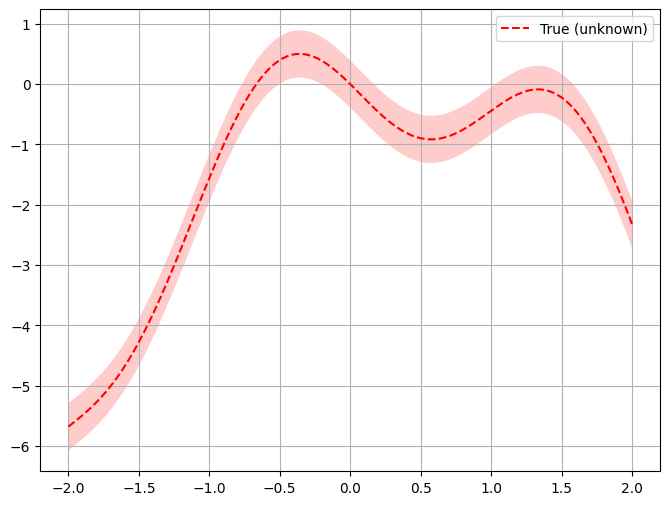

In [42]:
plt.rcParams["figure.figsize"] = (8,6)
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise for fx_i in fx],
                         [fx_i + 1.9600 * noise for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In [49]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern


# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)



res = gp_minimize(
    lambda x: -f(np.array(x)),  # the function to minimize
    bounds.tolist(),  # the bounds on each dimension of x
    acq_func="EI",  # the acquisition function
    xi=0.01,  # exploitation-exploration trade-off
    n_calls=15,  # the number of evaluations of f
    n_random_starts=5,  # the number of random initialization points
    # n_random_starts=0,  # initial samples are provided
    # x0=X_init.tolist(),  # initial samples
    # y0=-Y_init.ravel(),
    noise=0.1,  # the noise level (optional)
    random_state=1234, # the random seed
) 

# Fit GP model to samples for plotting results
gpr.fit(res.x_iters, -res.func_vals)

"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

c:\Users\Lenovo\Documents\Teaching\2025_2026\2025Z-AutoML\.venv\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [-1.0, 2.0] was inferred to Real(low=-1.0, high=2.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(-1.0, 2.0), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(


'x^*=-0.1881, f(x^*)=-0.6658'

- `x [float]`: location of the minimum.

- `fun [float]`: function value at the minimum.

- `models`: surrogate models used for each iteration.

- `x_iters [array]`: location of function evaluation for each iteration.

- `func_vals [array]`: function value for each iteration.

- `space [Space]`: the optimization space.

- `specs [dict]`: parameters passed to the function.

In [27]:
#print(res)

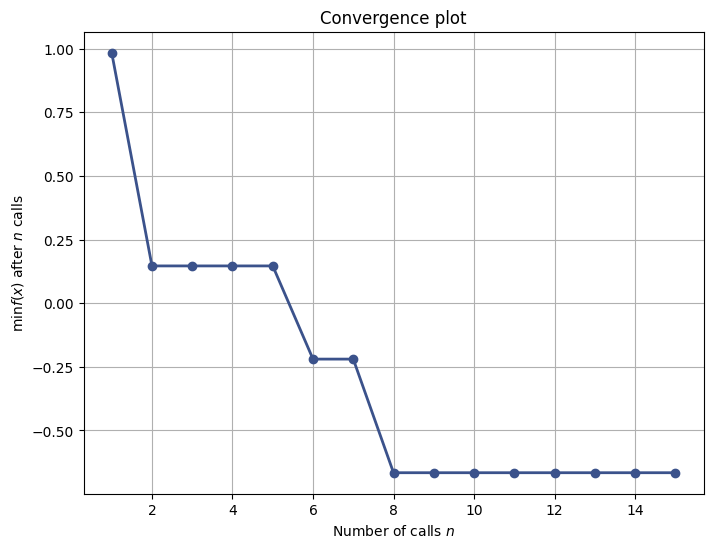

In [50]:
from skopt.plots import plot_convergence
plot_convergence(res);

In [53]:
plt.rcParams["figure.figsize"] = (8, 14)


def f_wo_noise(x):
    return -f(x, noise=0)

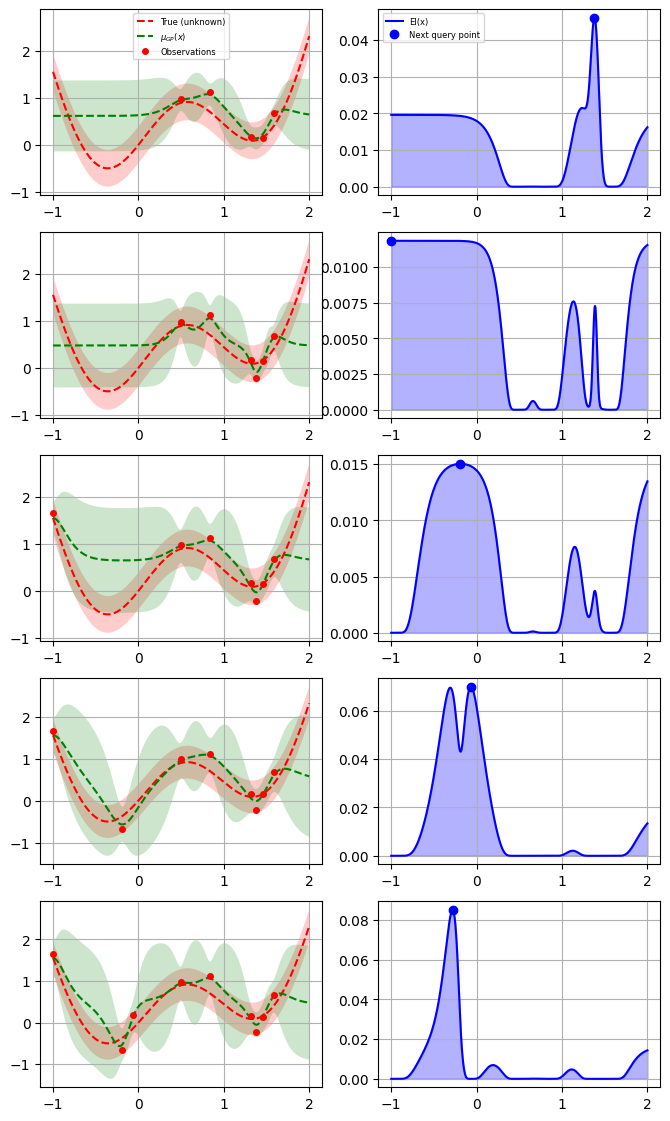

In [54]:
for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=noise,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

### Zadanie 1
Przetestuj w powyższym kodzie działanie różnych funkcji wyboru kolejnego punktu (ang. Acquisition Function) i porównaj wykresy zbieżności.

### Zadanie 2
Wykorzystując powyższy kod zoptymalizuj liczbę sąsiadów w algorytmie  `KNeighborsClassifier` lub parametr regularyzacyjny w algorytmie `LogisticRegression`, dla zbioru danych Adult (id = 45068) z repozytorium OpenML.

In [ ]:
import openml

# Lista dostępnych zbiorów danych
openml.datasets.list_datasets(output_format="dataframe")

# Wybór zbioru danych przed ID
dataset = openml.datasets.get_dataset(45068)

X, _, _, _ = dataset.get_data(dataset_format="dataframe")
y = X.loc[:, 'class']
X = X.drop(['class'], axis = 1)
print('Dane X', X.head())
print('Target: ', y.head())

### Uwaga

Funkcja `gp_optimize` może optymalizować funkcję, która przyjmuje jako argument  pojedynczą listę parametrów i zwraca wartość skalarną. Może być to problematyczne przy większej liczbie wymiarów i należy wyedy korzystać z dekoratora [skopt.utils.use_named_args()](https://scikit-optimize.github.io/stable/modules/generated/skopt.utils.use_named_args.html#skopt.utils.use_named_args)

## BayesSearchCV

Zdecydowanie wygodniejszą funkcją do stosowania w ML jest BayesSearchCV.

In [ ]:
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsClassifier

search = BayesSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': (1, 20)},
    n_iter=25,
    cv=3,
    random_state=42
)
search.fit(X, y)
print(search.best_params_, search.best_score_)

### Zadanie 3
Korzystając z BayesSearchCV zoptymalizuj `RandomForestClassifier`  dla minimum 3 hiperparametrów.

### Zadanie 4
Zoptymalizuj pipeline z poprzednich zajęć. Optymalizuj także wybór hiperparametrów technik preprocessingu. Porównaj działenie optymalizacji bayesowskiej z Random Search.

### Optuna

In [ ]:
# !pip install optuna

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

def objective(trial):
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1e1, log=True)
    model = SVC(C=C, gamma=gamma)
    score = cross_val_score(model, X, y, cv=3).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print(study.best_params, study.best_value)
